In [14]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid

# Build a Voronoi Mesh

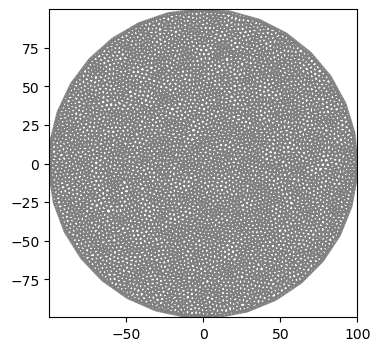

In [15]:
workspace = pl.Path("./temp")
workspace.mkdir(exist_ok=True)
theta = np.arange(0.0, 2 * np.pi, 0.2)
radius = 100.0
x = radius * np.cos(theta)
y = radius * np.sin(theta)
circle_poly = [(x, y) for x, y in zip(x, y)]
tri = Triangle(maximum_area=5, angle=30, model_ws=workspace)
tri.add_polygon(circle_poly)
tri.build(verbose=False)

voronoi_grid = VoronoiGrid(tri)
gridprops = voronoi_grid.get_gridprops_vertexgrid()
vertex_grid = flopy.discretization.VertexGrid(**gridprops, nlay=1)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot()
ax.set_aspect("equal")
vertex_grid.plot(ax=ax)

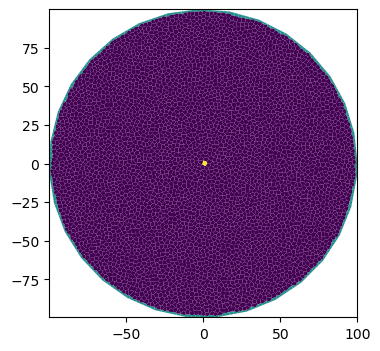

In [16]:
ibd = np.zeros(vertex_grid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vertex_grid)

# identify cells on outer edge
dtheta = .2
theta = np.arange(0.0, 2 * np.pi + dtheta, dtheta)
radius = 100.0 - 0.01
x = radius * np.cos(theta)
y = radius * np.sin(theta)
circle_poly = [(x, y) for x, y in zip(x, y)]
cells0 = gi.intersect(circle_poly, shapetype="linestring")["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cell in middle for a well
cells0 = gi.intersect([(0., 0.)], shapetype="point")["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 2

if True:
    fig = plt.figure(figsize=(4, 4))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vertex_grid)
    pmv.plot_array(ibd)

# Create DISV Version of Model

In [17]:
xt3doptions = [(True,)]

In [18]:
name = "mf"
sim_ws = pl.Path(workspace/ "disv_model")
sim = flopy.mf6.MFSimulation(
    sim_name=name, version="mf6", exe_name="mf6", sim_ws=sim_ws
)
tdis = flopy.mf6.ModflowTdis(
    sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]]
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    complexity="simple",
    linear_acceleration="bicgstab",
    outer_dvclose=1.0e-8,
    inner_dvclose=1.0e-8,
)
disv_gridprops = voronoi_grid.get_disv_gridprops()
nlay = 3
top = 10.0
botm = [0.0, -10, -50]
disv = flopy.mf6.ModflowGwfdisv(
    gwf, nlay=nlay, **disv_gridprops, top=top, botm=botm
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=xt3doptions,
    k=1.0,
    save_saturation=True,
    save_specific_discharge=True,
)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in np.where(ibd == 1)[0]:
    chdlist.append([(0, icpl), 0.])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
wellist = []
for icpl in np.where(ibd == 2)[0]:
    wellist.append([(2, icpl), -10.])
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=wellist)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.01)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord="{}.bud".format(name),
    head_filerecord="{}.hds".format(name),
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
)
sim.write_simulation()
success, buff = sim.run_simulation(report=True, silent=False)

head = gwf.output.head().get_data()
head_disv = head
bdobj = gwf.output.budget()
spdis = bdobj.get_data(text="DATA-SPDIS")[0]
spdis_disv = spdis

grb = flopy.mf6.utils.binarygrid_util.MfGrdFile(sim_ws / "mf.disv.grb")
ia_disv = grb.ia
ja_disv = grb.ja

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 252 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jun 14 2023 15:20:13 with GCC version 12.2.0

This software is preliminary or 

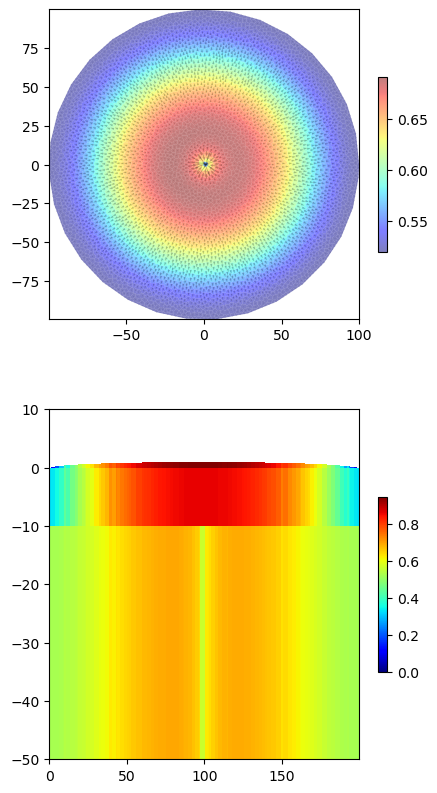

In [19]:
fig = plt.figure(figsize=(5, 10))

ax = plt.subplot(2, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(gwf, layer=2)
c = pmv.plot_array(head, cmap="jet", alpha=0.5)
pmv.plot_vector(spdis["qx"], spdis["qy"], alpha=0.25)
plt.colorbar(c, shrink=0.5)

ax = plt.subplot(2, 1, 2)
xsect = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(-100, 0), (100, 0)]})
pc = xsect.plot_array(head, head=head, cmap="jet") #, vmin=0, vmax=1)
plt.colorbar(pc, shrink=0.5)

# Create DISU Version of the Model

In [20]:
import disv2disu

from importlib import reload
reload(disv2disu)
Disv2Disu = disv2disu.Disv2Disu

gridprops = voronoi_grid.get_disv_gridprops()
vertices = gridprops["vertices"]
cell2d = gridprops["cell2d"]
ncpl = len(cell2d)
nlay = 3
top = 10 * np.ones(ncpl, dtype=float)
botm = np.empty((nlay, ncpl), dtype=float)
botm[0, :] = -0.
botm[1, :] = -10.
botm[2, :] = -50.
dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=True)

In [21]:
name = "mf"
sim_ws = pl.Path(workspace/ "disu_model")
sim = flopy.mf6.MFSimulation(
    sim_name=name, 
    version="mf6", 
    exe_name="mf6", 
    sim_ws=sim_ws,
)
tdis = flopy.mf6.ModflowTdis(
    sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]]
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    complexity="simple",
    linear_acceleration="bicgstab",
    outer_dvclose=1.0e-8,
    inner_dvclose=1.0e-8,
)
disu_gridprops = dv2d.get_gridprops_disu6()
disu = flopy.mf6.ModflowGwfdisu(
    gwf,
    **disu_gridprops
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=xt3doptions,
    k=1.0,
    save_saturation=True,
    save_specific_discharge=True,
)
ic = flopy.mf6.ModflowGwfic(gwf)

chdlist = []
for icpl in np.where(ibd == 1)[0]:
    chdlist.append([(icpl,), 0.])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)

wellist = []
for icpl in np.where(ibd == 2)[0]:
    wellist.append([((nlay - 1) * ncpl + icpl,), -10.])
wel = flopy.mf6.ModflowGwfwel(gwf, maxbound=ncpl, stress_period_data=wellist)

rchlist = []
for icpl in range(ncpl):
    rchlist.append([(icpl,), 0.01])
rch = flopy.mf6.ModflowGwfrch(gwf, stress_period_data=rchlist)

oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord="{}.bud".format(name),
    head_filerecord="{}.hds".format(name),
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
)
sim.write_simulation()
success, buff = sim.run_simulation(report=True, silent=False)

head = gwf.output.head().get_data()
head_disu = head
bdobj = gwf.output.budget()
spdis = bdobj.get_data(text="DATA-SPDIS")[0]
spdis_disu = spdis

grb = flopy.mf6.utils.binarygrid_util.MfGrdFile(sim_ws / "mf.disu.grb")
ia_disu = grb.ia
ja_disu = grb.ja

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf...
    writing model name file...
    writing package disu...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 252 based on size of stress_period_data
    writing package wel_0...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 5050 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 12/09/2022
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jun 14 2023 15:20:13 with GCC version 12.2.0

This software is preliminary o

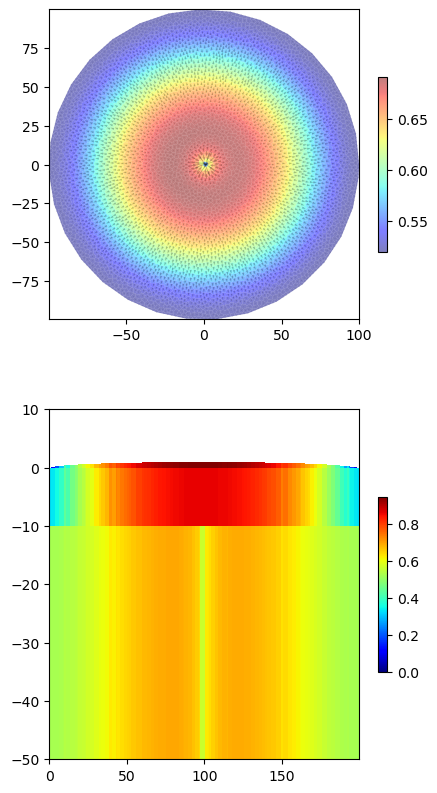

In [22]:
fig = plt.figure(figsize=(5, 10))

ax = plt.subplot(2, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(gwf, layer=2)
c = pmv.plot_array(head, cmap="jet", alpha=0.5)
pmv.plot_vector(spdis["qx"], spdis["qy"], alpha=0.25)
plt.colorbar(c, shrink=0.5)

ax = plt.subplot(2, 1, 2)
xsect = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(-100, 0), (100, 0)]})
pc = xsect.plot_array(head, head=head, cmap="jet") #, vmin=0, vmax=1)
plt.colorbar(pc, shrink=0.5)

In [23]:
assert np.allclose(np.reshape(head_disu, head_disv.shape), head_disv)

In [24]:
diff = np.reshape(head_disu, head_disv.shape) - head_disv
diff

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00, -9.56766610e-12, -9.48472967e-11]],

       [[-6.30006602e-11,  8.99691432e-12, -8.99541552e-12, ...,
         -2.71110911e-11, -2.96899172e-11, -4.28524438e-11]],

       [[-2.60035327e-11, -1.44458889e-11, -1.64266378e-11, ...,
         -2.30566677e-11, -2.31993313e-11, -1.78438375e-11]]])

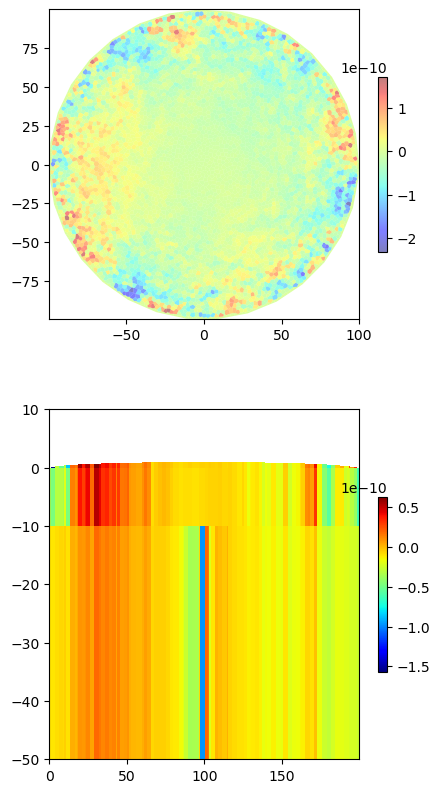

In [25]:
# plot difference in head between disu and disv
fig = plt.figure(figsize=(5, 10))
ax = plt.subplot(2, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(gwf, layer=0)
c = pmv.plot_array(diff, cmap="jet", alpha=0.5)
plt.colorbar(c, shrink=0.5)
ax = plt.subplot(2, 1, 2)
xsect = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"line": [(-100, 0), (100, 0)]})
pc = xsect.plot_array(diff, head=head, cmap="jet") #, vmin=0, vmax=1)
plt.colorbar(pc, shrink=0.5)

In [26]:
# check and make sure disv results are same as disu results
assert np.allclose(ia_disv, ia_disu, atol=0)
assert np.allclose(ja_disv, ja_disu, atol=0)
assert np.allclose(spdis_disv["node"], spdis_disu["node"], atol=0)
assert np.allclose(spdis_disv["node2"], spdis_disu["node2"], atol=0)
assert np.allclose(spdis_disv["q"], spdis_disu["q"], atol=0)
assert np.allclose(spdis_disv["qx"], spdis_disu["qx"], atol=1.e-7)
assert np.allclose(spdis_disv["qy"], spdis_disu["qy"], atol=1.e-7)
assert np.allclose(spdis_disv["qz"], spdis_disu["qz"], atol=1.e-7)